In [68]:
import pandas as pd
import polars as pl
import numpy as np
import glob
import os
import time
import psutil
import gc
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import input_file_name, regexp_extract
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
def loadCSVToDataFrame(path, prefix: str = "defined_prefix") -> pd.DataFrame:
    """
    Load multiple CSV files with a specific prefix from a fixed folder
    into a single pandas DataFrame, with memory/time tracking and filename column.

    Args:
        path (str): Path to folder containing CSV files.
        prefix (str): Prefix of the filenames to match.

    Returns:
        pd.DataFrame: Concatenated DataFrame of all matched CSV files.
    """
    start_time = time.time()
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 ** 2)  # MB

    # File matching pattern
    file_pattern = os.path.join(path, f"{prefix}*.csv")
    csv_files = glob.glob(file_pattern)

    if not csv_files:
        raise FileNotFoundError(f"No files found matching pattern: {file_pattern}")

    # Load and tag each file with filename
    df_list = []
    for file in csv_files:
        temp_df = pd.read_csv(file, engine='pyarrow')
        temp_df["source_file"] = os.path.splitext(os.path.basename(file))[0]  # Add filename column
        df_list.append(temp_df)

    combined_df = pd.concat(df_list, ignore_index=True)

    mem_after = process.memory_info().rss / (1024 ** 2)  # MB
    elapsed_time = time.time() - start_time

    print(f"✅ Loaded {len(csv_files)} files into DataFrame")
    print(f"⏱ Load time: {elapsed_time:.2f} seconds")
    print(f"💾 Memory before: {mem_before:.2f} MB")
    print(f"💾 Memory after:  {mem_after:.2f} MB")
    print(f"📊 DataFrame shape: {combined_df.shape}")

    return combined_df

In [3]:
#Due to a smaller data size, this function is not in use as Spark takes longer for data load operations

def readCombineCSVSafe(folder_path, prefix, max_memory_fraction=0.1):
    """
    Reads CSVs into a Spark or pandas DataFrame, measures load time,
    estimates memory usage, and adds a 'source_file' column with the file name.

    Parameters:
        folder_path (str): Path to folder containing CSV files.
        prefix (str): Prefix of files to match (e.g., "ACY").
        max_memory_fraction (float): Max fraction of available RAM for pandas conversion.

    Returns:
        tuple: (DataFrame, load_time_seconds)
    """
    spark = SparkSession.builder \
        .appName("Timed CSV Loader with Memory Check + Filename") \
        .master("local[*]") \
        .getOrCreate()

    file_pattern = f"{folder_path}/{prefix}*.csv"

    start_time = time.time()

    # Read CSVs and add source file path column
    df_spark = spark.read.csv(file_pattern, header=True, inferSchema=True) \
        .withColumn("source_file_path", input_file_name())

    # Extract only the file name from the path
    df_spark = df_spark.withColumn(
        "source_file",
        regexp_extract("source_file_path", r"([^/\\]+$)", 1)
    )

    total_rows = df_spark.count()
    total_columns = len(df_spark.columns)

    # Estimate dataset memory size
    sample_pdf = df_spark.limit(1000).toPandas()
    sample_size_bytes = sample_pdf.memory_usage(deep=True).sum()
    estimated_size_bytes = (sample_size_bytes / len(sample_pdf)) * total_rows

    available_mem_bytes = psutil.virtual_memory().available
    safe_limit_bytes = available_mem_bytes * max_memory_fraction

    load_time = time.time() - start_time

    print(f"⏱ Load time: {load_time:.2f} seconds")
    print(f"📊 Estimated dataset size: {estimated_size_bytes / (1024**2):.2f} MB")
    print(f"💾 Available memory limit: {safe_limit_bytes / (1024**2):.2f} MB")

    if estimated_size_bytes <= safe_limit_bytes:
        print(f"✅ Converting to pandas DataFrame ({total_rows} rows, {total_columns} columns)")
        return df_spark.toPandas(), load_time
    else:
        print(f"⚠ Too large for pandas. Returning Spark DataFrame.")
        return df_spark, load_time


In [4]:
def ram_usage():
    """
    Returns current RAM usage (used/total) in MB and percentage.
    """
    mem = psutil.virtual_memory()
    used_mb = mem.used / (1024 ** 2)
    total_mb = mem.total / (1024 ** 2)
    percent = mem.percent
    
    print(f"RAM Used: {used_mb:.2f} MB / {total_mb:.2f} MB ({percent}%)")
    #return mem.percent  # Returning percentage for programmatic use

In [5]:
#Functions created to separately analyze the different bus datasets
#This will be used at a later stage to analyze individual buses

def checkDataFrameStructure(df1, df2):
    """
        Check if DataFrames have same column names in same order.
        Simply return a boolean value if the column names match.
    """
    return list(df1.columns) == list(df2.columns)

def mergeDataFrames(df1, df2):
    """
        If same structure, concatenate and delete originals.
        Ensure to also delete the original dataframes 
    """
    if checkDataFrameStructure(df1, df2):
        merged_df = pd.concat([df1, df2], ignore_index=True)
        del df1
        del df2
        print("DataFrames had same structure — merged successfully.")
        return merged_df
    else:
        print("DataFrames do not have the same structure.")
        return None

In [6]:
def missingPercentage(df, extra_missing_values=None):
    """
    Calculates missing value percentage for each column.
    
    Parameters:
    - df: pandas DataFrame
    - extra_missing_values: list of values to treat as missing 
      (e.g., ['-', 'NA', 'N/A', ''])
    
    Returns:
    DataFrame with columns:
    - 'missing_count'
    - 'missing_percent'
    """
    df_copy = df.copy()

    # Replace extra placeholders with NaN
    if extra_missing_values is not None:
        df_copy.replace(extra_missing_values, np.nan, inplace=True)

    total_rows = len(df_copy)
    missing_count = df_copy.isnull().sum()
    missing_percent = (missing_count / total_rows) * 100

    result = pd.DataFrame({
        'missing_count': missing_count,
        'missing_percent': missing_percent
    }).sort_values(by='missing_percent', ascending=False)

    return result

In [7]:
def reduceMemoryUsage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial size: {start_mem:.2f} MB")
    
    # Store column info
    col_info = []

    for col in df.columns:
        col_type = df[col].dtype
        c_min, c_max = None, None  # default if not numeric

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min, c_max = df[col].min(), df[col].max()
            
            if str(col_type).startswith("int"):
                if c_min >= 0:
                    if c_max < 255:
                        df[col] = df[col].astype("uint8")
                    elif c_max < 65535:
                        df[col] = df[col].astype("uint16")
                    elif c_max < 4294967295:
                        df[col] = df[col].astype("uint32")
                    else:
                        df[col] = df[col].astype("uint64")
                else:
                    if np.iinfo("int8").min <= c_min <= np.iinfo("int8").max:
                        df[col] = df[col].astype("int8")
                    elif np.iinfo("int16").min <= c_min <= np.iinfo("int16").max:
                        df[col] = df[col].astype("int16")
                    elif np.iinfo("int32").min <= c_min <= np.iinfo("int32").max:
                        df[col] = df[col].astype("int32")
                    else:
                        df[col] = df[col].astype("int64")
                        
            elif str(col_type).startswith("float"):
                df[col] = pd.to_numeric(df[col], downcast="float")
                c_min, c_max = df[col].min(), df[col].max()  # recalc after downcast
                
        else:
            df[col] = df[col].astype("category")
        
        # Append column info
        col_info.append({
            "column": col,
            "dtype": df[col].dtype,
            "min": c_min,
            "max": c_max
        })
            
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Reduced size: {end_mem:.2f} MB ({100 * (start_mem - end_mem)/start_mem:.1f}% reduction)")

    # Convert collected info into DataFrame
    col_summary = pd.DataFrame(col_info)

    return df, col_summary


In [8]:
def getNonNumericCols(df):
    """
    Returns a list of column names in the DataFrame
    that are not numeric (includes object, category, bool, datetime, etc.).
    """
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    return non_numeric_cols

In [9]:
def removeOutliersIQR(df, column):
    """
    Detects outliers in a DataFrame column using the IQR method 
    and replaces them with NaN (to allow interpolation later).
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to process
    
    Returns:
        pd.DataFrame: DataFrame with outliers replaced by NaN
    """
    # Calculate Q1 and Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN
    df[column] = df[column].where(
        (df[column] >= lower_bound) & (df[column] <= upper_bound),
        np.nan
    )
    
    return df

In [10]:
def handleMissingSensorData(df, col, method='auto'):
    if method == 'auto':
        # Forward-fill short gaps, interpolate medium gaps
        df[col] = df[col].ffill(limit=5)  # up to 5 consecutive missing
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    elif method == 'ffill':
        df[col] = df[col].ffill().bfill()
    elif method == 'interpolate':
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    return df

In [11]:
def reduceDrivingFeatures(df: pd.DataFrame, corr_threshold: float = 0.9) -> pd.DataFrame:
    """
    Reduce odometry/traction/status features by combining redundant ones and
    removing highly correlated columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with all features.
    corr_threshold : float, default=0.9
        Threshold for removing correlated features.
    
    Returns
    -------
    pd.DataFrame
        Reduced dataframe with fewer, more informative features.
    """
    
    # --- Domain-driven reduction ---
    # Combine wheel speeds into mean and differences
    df = df.copy()
    
    # --- Domain-driven reduction ---
    wheel_cols = [
        'odometry_wheelSpeed_fl', 'odometry_wheelSpeed_fr',
        'odometry_wheelSpeed_ml', 'odometry_wheelSpeed_mr',
        'odometry_wheelSpeed_rl', 'odometry_wheelSpeed_rr'
    ]
    
    # Fill NaNs in wheel speeds with 0 (or you can choose another strategy)
    df[wheel_cols] = df[wheel_cols].fillna(0)
    
    # Mean wheel speed
    df['wheelSpeed_mean'] = df[wheel_cols].mean(axis=1)
    
    # Left-right difference
    df['wheelSpeed_left_right_diff'] = (
        (df['odometry_wheelSpeed_fl'] + df['odometry_wheelSpeed_ml'] + df['odometry_wheelSpeed_rl']) / 3
        - (df['odometry_wheelSpeed_fr'] + df['odometry_wheelSpeed_mr'] + df['odometry_wheelSpeed_rr']) / 3
    )
    
    # Combine brake flags into a single categorical feature
    df['brake_status'] = (
        pd.to_numeric(df['status_haltBrakeIsActive'], errors='coerce').fillna(0).astype(int) +
        2 * pd.to_numeric(df['status_parkBrakeIsActive'], errors='coerce').fillna(0).astype(int)
        )
    # 0 = no brake, 1 = halt brake, 2 = park brake, 3 = both
    
    # Drop raw features already aggregated
    drop_cols = [
        'odometry_wheelSpeed_fl', 'odometry_wheelSpeed_fr',
        'odometry_wheelSpeed_ml', 'odometry_wheelSpeed_mr',
        'odometry_wheelSpeed_rl', 'odometry_wheelSpeed_rr',
        'status_haltBrakeIsActive', 'status_parkBrakeIsActive'
    ]
    df_reduced = df.drop(columns=drop_cols, errors="ignore")

    #These features are generalized versions of the metadata. We do not need them for prediction purposes.
    drop_generalized = ['drivenDistance', 'energyConsumption']
    
    df_reduced = df_reduced.drop(columns=drop_generalized, errors="ignore")
    
    # --- Statistical reduction ---
    # Remove highly correlated features
    #corr = df_reduced.corr().abs()
    #upper = corr.where(~pd.np.tril(pd.np.ones(corr.shape)).astype(bool))  # upper triangle
    #to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
    #df_final = df_reduced.drop(columns=to_drop, errors="ignore")
    
    return df_reduced


In [ ]:
def plotNumericCorrelations(df: pd.DataFrame, corr_threshold: float = 0.9):
    """
    Plot correlation heatmap for numerical features and list highly correlated pairs.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with features.
    corr_threshold : float, default=0.9
        Threshold above which features are considered correlated.

    Returns
    -------
    correlated_pairs : list of tuples
        List of correlated feature pairs with correlation above threshold.
    """
    # Select only numeric columns (all int/float types)
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute correlation matrix
    corr = numeric_df.corr()

    # --- Plot heatmap ---
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Correlation coefficient")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Numerical Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Extract correlated features ---
    correlated_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > corr_threshold:
                correlated_pairs.append((
                    corr.columns[i],
                    corr.columns[j],
                    corr.iloc[i, j]
                ))
    
    return correlated_pairs

In [70]:
def condenseMinMaxMean(df: pd.DataFrame, min_col: str, mean_col: str, max_col: str,
                          method: str = "weighted", weights: tuple = (0.2, 0.6, 0.2), 
                          lambda_: float = 0.1, new_col: str = "condensed_feature"):
    """
    Condense min, mean, max into one variable using different strategies.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    min_col, mean_col, max_col : str
        Column names for min, mean, and max.
    method : str, default "weighted"
        Method to condense features:
        - "weighted" → weighted average of (min, mean, max).
        - "range_mean" → mean + lambda * (max - min).
        - "pca" → first principal component of [min, mean, max].
    weights : tuple of length 3, default (0.2, 0.6, 0.2)
        Weights for (min, mean, max) when method="weighted".
    lambda_ : float, default 0.1
        Weight for variability (max - min) when method="range_mean".
    new_col : str, default "condensed_feature"
        Name of the new column.
    
    Returns
    -------
    - If method in {"weighted", "range_mean"}:
        pd.DataFrame
    - If method == "pca":
        (pd.DataFrame, PCA object)
    """
    
    df_copy = df.copy()
    
    if method == "weighted":
        a, b, c = weights
        df_copy[new_col] = a * df_copy[min_col] + b * df_copy[mean_col] + c * df_copy[max_col]
        return df_copy
    
    elif method == "range_mean":
        df_copy[new_col] = df_copy[mean_col] + lambda_ * (df_copy[max_col] - df_copy[min_col])
        return df_copy
    
    elif method == "pca":
        X = df_copy[[min_col, mean_col, max_col]].values
        pca = PCA(n_components=1)
        df_copy[new_col] = pca.fit_transform(X)
        return df_copy, pca
    
    else:
        raise ValueError("method must be 'weighted', 'range_mean', or 'pca'")

In [75]:
def condenseFeatures(df, feature_prefix, drop_original=True):
    """
    Condense min, mean, max time-series features into a single PCA component 
    and optionally drop the original columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns with suffixes '_min', '_mean', '_max'
    feature_prefix : str
        The prefix of the feature (e.g. 'speed', 'power')
    drop_original : bool, default=True
        If True, drop the original min/mean/max columns
    
    Returns
    -------
    pd.DataFrame
        Updated dataframe with the new PCA feature
    """
    cols = [f"{feature_prefix}_min", f"{feature_prefix}_mean", f"{feature_prefix}_max"]

    # Drop rows with NaN for PCA calculation
    X = df[cols].dropna()

    # Fit PCA (1 component)
    pca = PCA(n_components=1)
    condensed = pca.fit_transform(X)

    print(f"Explained variance ratio for {feature_prefix}: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"Component weights: {pca.components_[0]} (min, mean, max order)")

    # Assign back into df
    df.loc[X.index, f"{feature_prefix}_pca"] = condensed.flatten()

    # Drop original columns if requested
    if drop_original:
        df = df.drop(columns=cols)

    return df

In [80]:
def condenseFeaturesHighVariance(df, feature_set, new_feature_name, drop_original=True, threshold=0.99):
    """
    Condense min, mean, max (or similar correlated features) into a single feature.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        feature_set (list): List of correlated features [min, mean, max]
        new_feature_name (str): Name for the condensed feature
        drop_original (bool): Whether to drop original features
        threshold (float): Variance threshold for shortcut (default=0.99)
    
    Returns:
        pd.DataFrame: DataFrame with new condensed feature
    """
    # Select features
    X = df[feature_set].dropna()
    
    # Fit PCA
    pca = PCA(n_components=1)
    pca.fit(X)
    
    explained_var = pca.explained_variance_ratio_[0]
    
    if explained_var >= threshold:
        # ✅ Strong collinearity → just take the mean
        df[new_feature_name] = df[feature_set].mean(axis=1)
        print(f"Using MEAN instead of PCA (explained variance = {explained_var:.4f})")
    else:
        # ⚙️ Use PCA transformation
        df[new_feature_name] = pca.transform(df[feature_set])[:, 0]
        print(f"Using PCA (explained variance = {explained_var:.4f})")
        print(f"PCA components: {pca.components_}")
    
    # Drop original features if requested
    if drop_original:
        df = df.drop(columns=feature_set)
    
    return df

In [12]:
os.getcwd()

'E:\\datapao'

In [13]:
data_path = "E:/datapao/ZTBus/"

In [14]:
metadata = pd.read_csv('metaData.csv')
metadata = metadata.drop(columns = ['startTime_iso', 'startTime_unix', 'endTime_iso', 'endTime_unix'])

-- Markdown Section

In [15]:
#B183_pandasDF = loadCSVToDataFrame(data_path, "B183*")
#B208_pandasDF = loadCSVToDataFrame(data_path, "B208*")
#B208_pandasDF.head()
#B183_pandasDF = B183_pandasDF.merge(metadata2, left_on = 'source_file', right_on = 'name', how = 'left')
#B208_pandasDF = B208_pandasDF.merge(metadata2, left_on = 'source_file', right_on = 'name', how = 'left')

In [16]:
ram_usage()

RAM Used: 7950.73 MB / 32471.92 MB (24.5%)


In [17]:
ZTBus = loadCSVToDataFrame(data_path, "B*")

✅ Loaded 1409 files into DataFrame
⏱ Load time: 142.40 seconds
💾 Memory before: 240.30 MB
💾 Memory after:  20637.73 MB
📊 DataFrame shape: (48674462, 27)


In [18]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 10026.63 MB
Reduced size: 5431.14 MB (45.8% reduction)


In [19]:
ZTBus = ZTBus.merge(metadata, left_on = 'source_file', right_on = 'name', how = 'left')

In [20]:
del metadata

In [21]:
gc.collect()

0

In [22]:
ram_usage()

RAM Used: 17708.32 MB / 32471.92 MB (54.5%)


In [23]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 10165.89 MB
Reduced size: 7380.80 MB (27.4% reduction)


In [24]:
ZTBus.describe()

,time_unix,electric_powerDemand,gnss_altitude,gnss_course,gnss_latitude,gnss_longitude,itcs_numberOfPassengers,odometry_articulationAngle,odometry_steeringAngle,odometry_vehicleSpeed,...,busNumber,drivenDistance,energyConsumption,itcs_numberOfPassengers_mean,itcs_numberOfPassengers_min,itcs_numberOfPassengers_max,status_gridIsAvailable_mean,temperature_ambient_mean,temperature_ambient_min,temperature_ambient_max
count,4.867446e+07,4.867446e+07,4.734358e+07,4.734528e+07,4.734529e+07,4.734529e+07,444738.000000,4.867446e+07,4.867446e+07,4.867446e+07,...,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07
mean,1.627992e+09,2.478952e+04,4.400245e+02,2.602361e+00,8.270245e-01,1.487024e-01,17.887466,1.752685e-02,2.267342e-02,4.263831e+00,...,1.921352e+02,1.985147e+05,1.154825e+09,1.784426e+01,2.312103e-01,6.585355e+01,6.590821e-01,2.893997e+02,2.852818e+02,2.956784e+02
std,3.330665e+07,6.784718e+04,3.257275e+01,2.011340e+00,2.476776e-04,3.746242e-04,13.821078,8.845592e-02,1.155644e-01,4.207733e+00,...,1.203861e+01,8.190737e+04,4.995213e+08,5.430501e+00,6.629398e-01,2.175455e+01,2.109425e-01,7.288150e+00,6.228632e+00,5.626224e+00
min,1.556594e+09,-3.227970e+05,-1.011752e+03,0.000000e+00,8.225854e-01,-5.114448e-02,0.000000,-9.424800e-01,-9.424800e-01,-8.477243e-01,...,1.830000e+02,3.886427e+04,1.947412e+08,1.685185e+00,0.000000e+00,8.000000e+00,2.165135e-01,2.741103e+02,2.731500e+02,2.791500e+02
25%,1.604595e+09,3.186402e+03,4.151000e+02,5.776362e-01,8.268975e-01,1.483610e-01,8.000000,8.726646e-03,0.000000e+00,0.000000e+00,...,1.830000e+02,1.475090e+05,8.370118e+08,1.435750e+01,0.000000e+00,5.000000e+01,4.698786e-01,2.830275e+02,2.801500e+02,2.911500e+02
50%,1.635432e+09,9.666712e+03,4.257716e+02,2.401412e+00,8.270337e-01,1.487095e-01,15.000000,1.745333e-02,8.726667e-03,3.557555e+00,...,1.830000e+02,2.098937e+05,1.213240e+09,1.794090e+01,0.000000e+00,6.400000e+01,5.329543e-01,2.895523e+02,2.854970e+02,2.941500e+02
75%,1.656400e+09,4.378899e+04,4.714848e+02,4.413938e+00,8.272278e-01,1.489492e-01,24.000000,4.363333e-02,3.490667e-02,7.874786e+00,...,2.080000e+02,2.489304e+05,1.506657e+09,2.120461e+01,0.000000e+00,8.100000e+01,8.815500e-01,2.950798e+02,2.911500e+02,2.991500e+02
max,1.670729e+09,3.813403e+05,4.657081e+03,6.283185e+00,8.537830e-01,1.594845e-01,131.000000,9.337533e-01,9.424800e-01,1.920769e+01,...,2.080000e+02,3.867413e+05,2.684731e+09,3.980899e+01,1.700000e+01,1.310000e+02,1.000000e+00,3.075008e+02,3.031500e+02,3.111500e+02


In [25]:
#ZTBus.head()

In [26]:
print(getNonNumericCols(ZTBus))

['time_iso', 'itcs_busRoute', 'itcs_stopName', 'source_file', 'name', 'busRoute']


In [27]:
print(missingPercentage(ZTBus))

                              missing_count  missing_percent
itcs_numberOfPassengers            48229724        99.086301
gnss_altitude                       1330884         2.734255
gnss_course                         1329182         2.730758
gnss_longitude                      1329169         2.730732
gnss_latitude                       1329169         2.730732
status_gridIsAvailable                  109         0.000224
status_haltBrakeIsActive                109         0.000224
status_doorIsOpen                       109         0.000224
status_parkBrakeIsActive                109         0.000224
temperature_ambient                     103         0.000212
electric_powerDemand                      0         0.000000
time_unix                                 0         0.000000
time_iso                                  0         0.000000
itcs_stopName                             0         0.000000
itcs_busRoute                             0         0.000000
odometry_wheelSpeed_fr  

In [28]:
ZTBus.drop(columns = ['itcs_numberOfPassengers', 'time_iso', 'itcs_stopName', 'source_file', 'name'], inplace = True)

In [29]:
#print(missing_percentage(ZTBus))

In [30]:
gc.collect()

0

In [31]:
ram_usage()

RAM Used: 13133.68 MB / 32471.92 MB (40.4%)


In [32]:
# Memory in GB
mem_gb = ZTBus.memory_usage(deep=True).sum() / (1024 ** 3)
print(f"DataFrame uses {mem_gb:.2f} GB")

DataFrame uses 6.39 GB


--- This sections starts the treatment of missing values in the dataframe ---

-- Start Visualization of Missing GNSS Sensor --

-- From the missing percentage analysis, we see the sensor data has an approximately 2.7% is missing in all 4. So we use interpolation methods to resolve it. -- 

C:\Users\Saransh\AppData\Local\Temp\ipykernel_2188\20084677.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Temp\ipykernel_2188\20084677.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


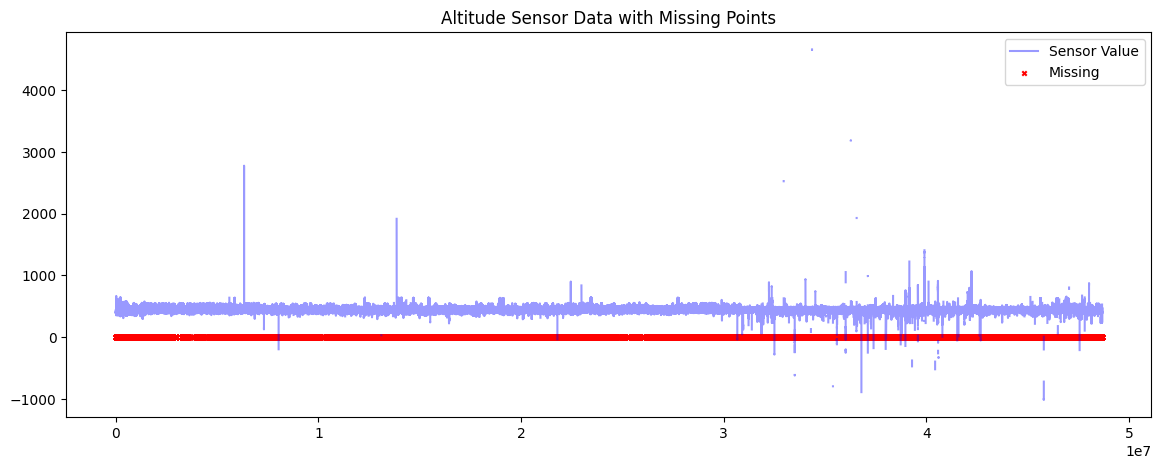

In [34]:
plt.figure(figsize=(14, 5))
plt.plot(ZTBus.index, ZTBus['gnss_altitude'], color='blue', alpha=0.4, label='Sensor Value')

# Plot missing points
plt.scatter(ZTBus.index[ZTBus['gnss_altitude'].isna()], 
            [0]*ZTBus['gnss_altitude'].isna().sum(), 
            color='red', marker='x', label='Missing', s=10)

plt.title('Altitude Sensor Data with Missing Points')
plt.legend()

# Save as JPG
plt.savefig("altitude_sensor_plot.jpg", dpi=300, bbox_inches="tight") 

plt.show()

In [35]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_altitude')

In [36]:
ZTBus['timestamp'] = pd.to_datetime(ZTBus['time_unix'], unit='s')

In [37]:
ZTBus.drop(columns = ['time_unix'], inplace = True)

In [40]:
ZTBus = removeOutliersIQR(ZTBus, 'gnss_altitude')

C:\Users\Saransh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


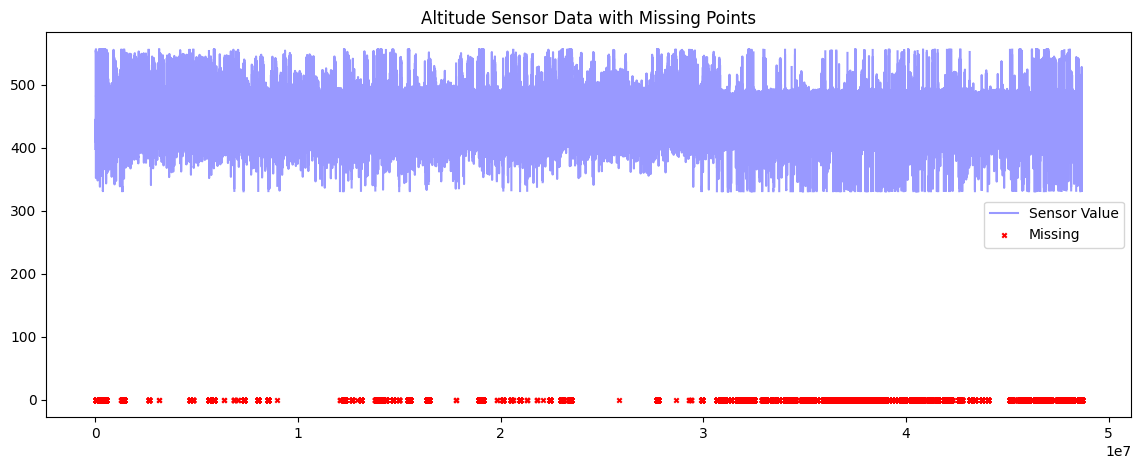

In [41]:
plt.figure(figsize=(14, 5))
plt.plot(ZTBus.index, ZTBus['gnss_altitude'], color='blue', alpha=0.4, label='Sensor Value')

# Plot missing points
plt.scatter(ZTBus.index[ZTBus['gnss_altitude'].isna()], 
            [0]*ZTBus['gnss_altitude'].isna().sum(), 
            color='red', marker='x', label='Missing', s=10)

plt.title('Altitude Sensor Data with Missing Points')
plt.legend()
plt.show()

In [42]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_altitude')

C:\Users\Saransh\AppData\Local\Temp\ipykernel_2188\3494837249.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_clean_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Temp\ipykernel_2188\3494837249.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_clean_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


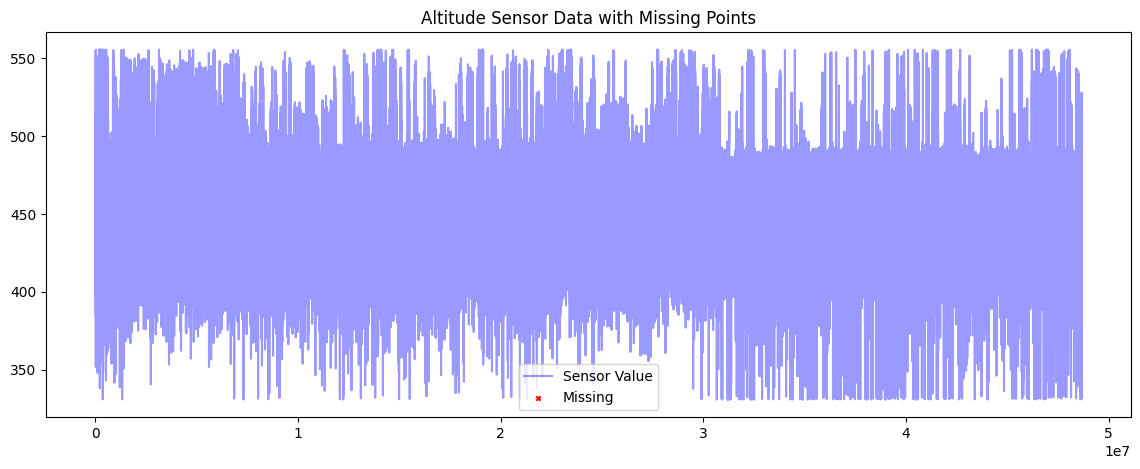

In [43]:
plt.figure(figsize=(14, 5))
plt.plot(ZTBus.index, ZTBus['gnss_altitude'], color='blue', alpha=0.4, label='Sensor Value')

# Plot missing points
plt.scatter(ZTBus.index[ZTBus['gnss_altitude'].isna()], 
            [0]*ZTBus['gnss_altitude'].isna().sum(), 
            color='red', marker='x', label='Missing', s=10)

plt.title('Altitude Sensor Data with Missing Points')
plt.legend()

# Save as JPG
plt.savefig("altitude_sensor_clean_plot.jpg", dpi=300, bbox_inches="tight")

plt.show()

In [44]:
ZTBus = ZTBus.sort_values("timestamp")

#ZTBus['gnss_latitude'] = ZTBus.groupby('timestamp')['gnss_latitude'].transform(lambda x: x.interpolate())
#ZTBus['gnss_longitude'] = ZTBus.groupby('timestamp')['gnss_longitude'].transform(lambda x: x.interpolate())

In [45]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_latitude')

In [46]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_longitude')

In [47]:
coords = ZTBus[['gnss_latitude', 'gnss_longitude']]
kmeans = KMeans(n_clusters=20, random_state=42)
ZTBus['location_cluster'] = kmeans.fit_predict(coords)

In [48]:
ZTBus.drop(columns= ['gnss_latitude', 'gnss_longitude'], inplace = True)

In [49]:
ZTBus.location_cluster.unique()

array([ 1,  3, 11,  2, 17, 16,  9, 13, 18,  7,  8,  6, 19, 14,  5,  4,  0,
       15, 12, 10], dtype=int32)

In [50]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 6916.52 MB
Reduced size: 6777.26 MB (2.0% reduction)


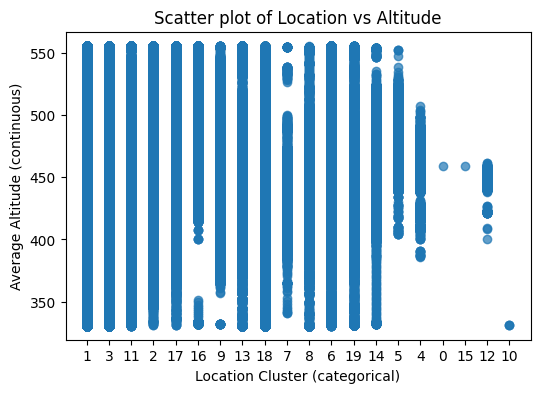

In [51]:
ZTBus["location_cluster"] = ZTBus["location_cluster"].astype(str)

# Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(ZTBus["location_cluster"], ZTBus["gnss_altitude"], alpha=0.7)

plt.xlabel("Location Cluster (categorical)")
plt.ylabel("Average Altitude (continuous)")
plt.title("Scatter plot of Location vs Altitude")
plt.show()

In [52]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 7102.20 MB
Reduced size: 6777.26 MB (4.6% reduction)


In [53]:
gc.collect()

4189

In [54]:
ZTBus = reduceDrivingFeatures(ZTBus)

In [56]:
gc.collect()

0

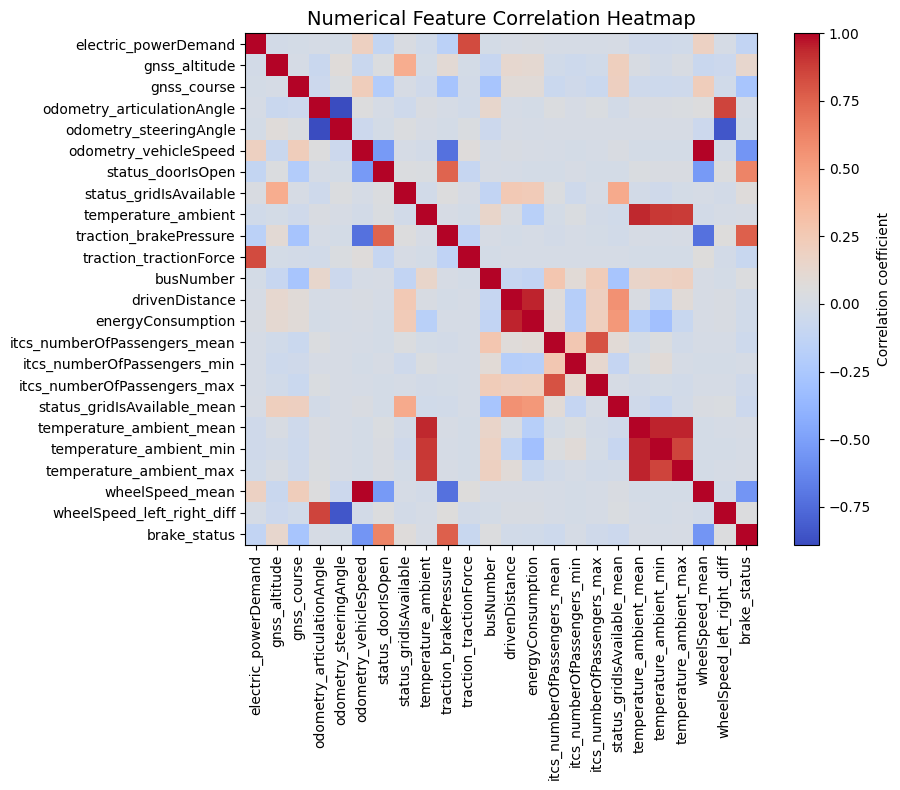

In [57]:
correlated = plotNumericCorrelations(ZTBus, corr_threshold=0.85)

In [58]:
gc.collect()

8810

In [59]:
print("Highly correlated feature pairs:")
for f1, f2, val in correlated:
    print(f"{f1} ↔ {f2} : corr = {val:.2f}")

Highly correlated feature pairs:
odometry_articulationAngle ↔ odometry_steeringAngle : corr = -0.89
odometry_articulationAngle ↔ wheelSpeed_left_right_diff : corr = 0.85
odometry_vehicleSpeed ↔ wheelSpeed_mean : corr = 1.00
temperature_ambient ↔ temperature_ambient_mean : corr = 0.94
temperature_ambient ↔ temperature_ambient_min : corr = 0.89
temperature_ambient ↔ temperature_ambient_max : corr = 0.89
drivenDistance ↔ energyConsumption : corr = 0.95
temperature_ambient_mean ↔ temperature_ambient_min : corr = 0.95
temperature_ambient_mean ↔ temperature_ambient_max : corr = 0.94
temperature_ambient_min ↔ temperature_ambient_max : corr = 0.86


In [60]:
print(getNonNumericCols(ZTBus))

['itcs_busRoute', 'busRoute', 'timestamp', 'location_cluster']


In [61]:
ZTBus["itcs_busRoute"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_busRoute,,
-,48235091,99.097327
83,198875,0.408582
33,90427,0.185779
72,73254,0.150498
46,50899,0.104570
32,9702,0.019932
31,7453,0.015312
N2,4839,0.009942
N4,1989,0.004086


In [63]:
ZTBus["busRoute"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
busRoute,,
83,24420202,50.170461
33,8119864,16.681980
72,7975176,16.384723
46,4771365,9.802604
32,1026054,2.107992
31,802922,1.649576
N2,556045,1.142375
-,545269,1.120236
N4,242544,0.498298


-- As there is no way to estimate the bus route where none is provided, the best way is to remove the rows all together. --

In [64]:
ZTBus["itcs_numberOfPassengers_mean"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_numberOfPassengers_mean,,
18.719610,86188,0.177070
15.138730,78812,0.161917
20.383591,77634,0.159496
23.536949,73890,0.151804
18.237610,73379,0.150755
...,...,...
19.738640,10860,0.022311
36.544300,10846,0.022283
17.238640,10826,0.022242


-- We cannot have half a person boarding the bus, thus, we should round the values up to account for errors in the mean number of passengers --

In [65]:
ZTBus["itcs_numberOfPassengers_min"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_numberOfPassengers_min,,
0,40767952,83.756348
1,5746956,11.806922
2,1558000,3.200857
3,321046,0.659578
4,185414,0.380927
6,49708,0.102123
5,19062,0.039162
7,15478,0.031799
17,10846,0.022283


In [66]:
ZTBus["itcs_numberOfPassengers_max"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_numberOfPassengers_max,,
68,1105393,2.270992
54,1097612,2.255006
59,1082072,2.223080
78,1063422,2.184764
58,1047569,2.152194
...,...,...
17,34086,0.070029
110,28636,0.058832
10,18410,0.037823


In [71]:
# PCA-based
ZTBus_pca, pca_model = condenseMinMaxMean(ZTBus, "itcs_numberOfPassengers_min", 
                                        "itcs_numberOfPassengers_mean", "itcs_numberOfPassengers_max", 
                                        method="pca")

In [72]:
print("Explained variance ratio:", pca_model.explained_variance_ratio_)
print("PCA components:", pca_model.components_)

Explained variance ratio: [0.9796998]
PCA components: [[0.00389284 0.20196298 0.97938544]]


In [76]:
# PCA-based
ZTBus_pca, pca_model = condenseMinMaxMean(ZTBus, "temperature_ambient_min", 
                                        "temperature_ambient_mean", "temperature_ambient_max", 
                                        method="pca")

In [77]:
print("Explained variance ratio:", pca_model.explained_variance_ratio_)
print("PCA components:", pca_model.components_)

Explained variance ratio: [1.]
PCA components: [[0.5158803  0.6644553  0.54070944]]


In [79]:
ZTBus = condenseFeatures(ZTBus, "itcs_numberOfPassengers")

Explained variance ratio for itcs_numberOfPassengers: 0.9797
Component weights: [0.00389284 0.20196298 0.97938544] (min, mean, max order)


In [81]:
ZTBus = condenseFeaturesHighVariance(ZTBus, 
                       feature_set=["temperature_ambient_min", 
                                        "temperature_ambient_mean", "temperature_ambient_max"], 
                       new_feature_name="temperatureCondensed")

Using MEAN instead of PCA (explained variance = 1.0000)


In [82]:
#Drop Column due to extremely high missing values

ZTBus.drop(columns= ['itcs_busRoute'], inplace = True)

In [85]:
ZTBus.shape

(48674462, 23)